In [1]:
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'Arial',
        'size'   : 8}
matplotlib.rc('font', **font)

sys.path.insert(0, '../scripts/')
import mcl_functions as mf

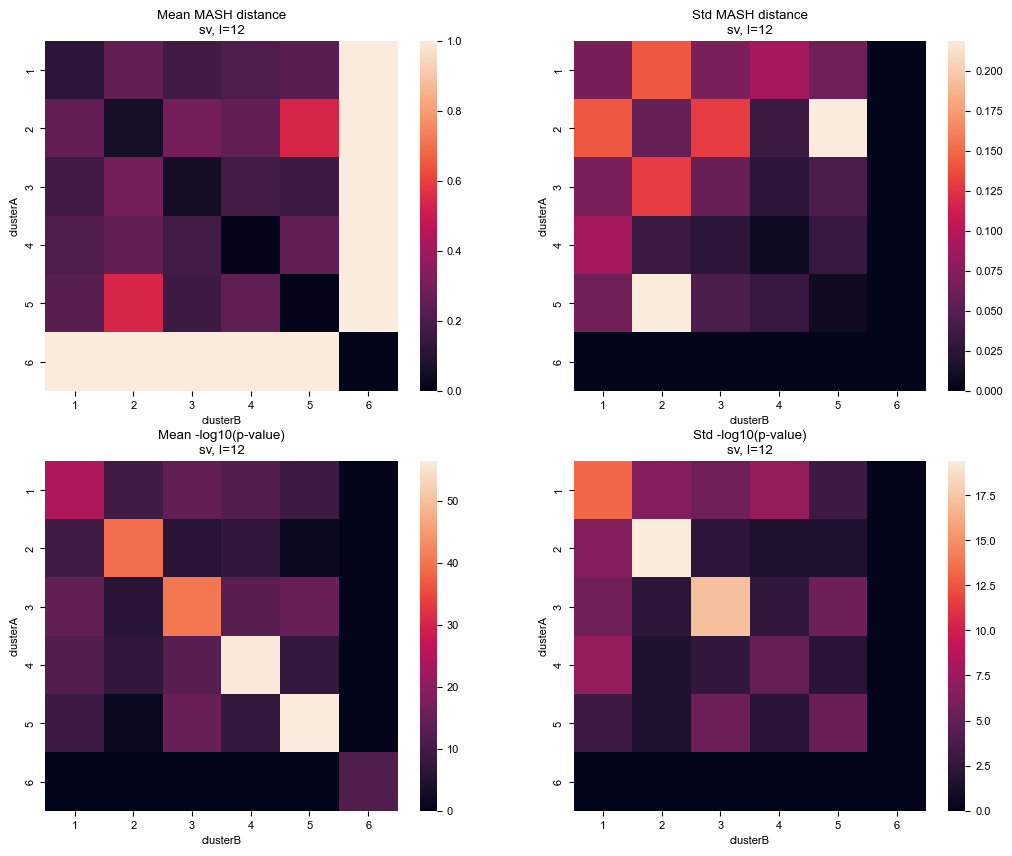

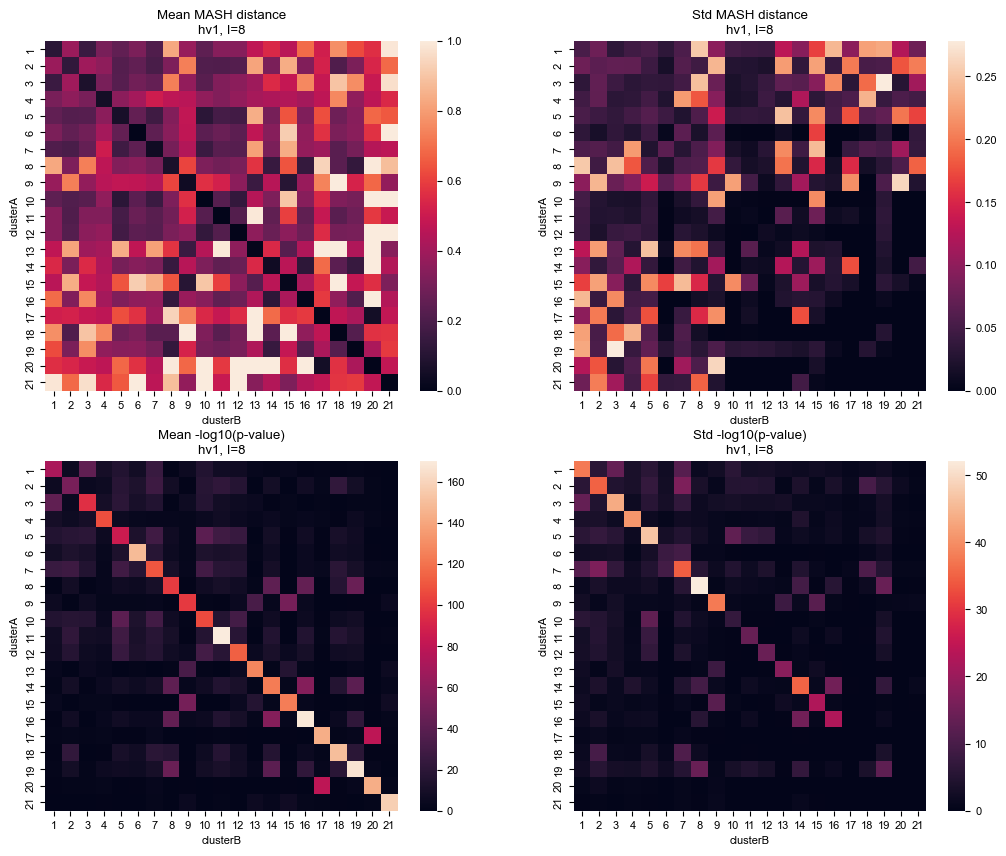

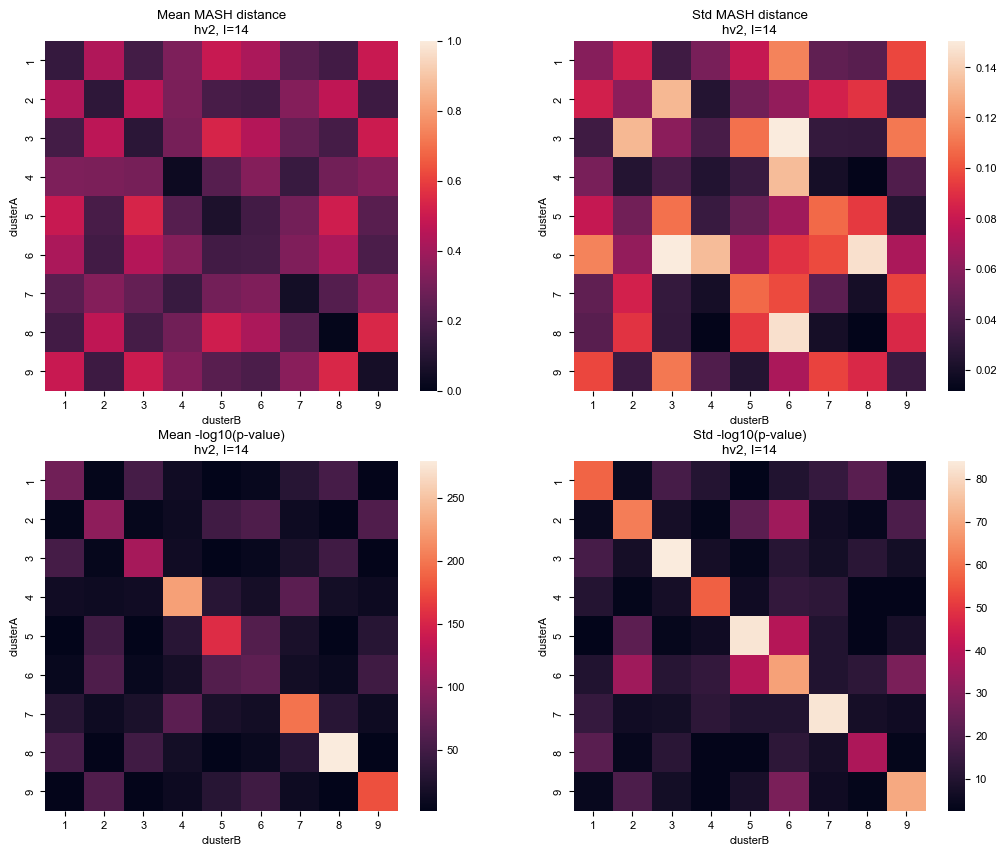

In [2]:
regions = ['sv', 'hv1', 'hv2']
inflations = [12, 8, 14]
for i in range(len(regions)):
    region = regions[i]
    mash = pd.read_csv('../../results/mash/' + region + '_mash_distance.tab', delimiter = '\t', header = None, names = ['reference_id', 'query_id', 'mash_distance', 'pvalue', 'matching_hashes'])
    inflation = inflations[i]

    clusters = mf.parse_mcl_clusters('../../results/mcl/dump.' + region + '.nci.I' + str(int(inflation*10)))
    
    # Remove reference sequence
    clusters = clusters[clusters['id']!='FA1090_opa_1_reference']

    # Merge MASH distance dataframe with the dataframe that indicates the clusters of each sequence
    mash_clusters = mash.merge(clusters, left_on = 'reference_id', right_on = 'id')
    mash_clusters.rename({'cluster':'reference_cluster'}, axis =1, inplace = True)
    mash_clusters.drop(labels = ['id'], axis = 1, inplace = True)
    mash_clusters = mash_clusters.merge(clusters, left_on = 'query_id', right_on = 'id')
    mash_clusters.rename({'cluster':'query_cluster'}, axis =1, inplace = True)
    mash_clusters.drop(labels = ['id'], axis = 1, inplace = True)

    # Drop the rows that are identical so that we don't bias the within-cluster comparisons to be lower by comparing the same thing to itself
    mash_clusters = mash_clusters[~(mash_clusters['reference_id']==mash_clusters['query_id'])]
    mash_clusters.reset_index(drop = True, inplace = True)
    mash_clusters

    # Calculate within and between cluster metrics
    distances_dict = {}
    neglog10pvalues_dict = {}
    clusterA = []
    clusterB = []
    mean_dist = []
    std_dist = []
    mean_nl10pvalues = []
    std_nl10pvalues = []
    num_seqs_clusterA = []
    num_seqs_clusterB = []
    for cluster_pair, df in mash_clusters.groupby(['reference_cluster', 'query_cluster']):
            # Note that this double counts opa_id_A,opa_id_B and opa_id_B,opa_id_A pairs (which may have different distances and p-values), but since this double counting occurs for all pairs, it should not affect the overall results
            # The stds might be underestimated due to this
            
            # Set the p-values that are 0 to the lowest value represented in python
            df.loc[df['pvalue']==0, 'pvalue'] = 10**-323
            clusterA.append(cluster_pair[0])
            clusterB.append(cluster_pair[1])
            mean_dist.append(np.mean(df['mash_distance'].values))
            std_dist.append(np.std(df['mash_distance'].values))
            mean_nl10pvalues.append(np.mean((-1)*np.log10(df['pvalue'].values)))
            std_nl10pvalues.append(np.std((-1)*np.log10(df['pvalue'].values)))
            num_seqs_clusterA.append(len(np.unique(df['reference_id'])))
            num_seqs_clusterB.append(len(np.unique(df['query_id'])))

            distances_dict[cluster_pair] = df['mash_distance'].values
            neglog10pvalues_dict[cluster_pair] = (-1)*np.log10(df['pvalue'].values)
            
    cluster_summary = pd.DataFrame({'clusterA':clusterA, 'clusterB':clusterB, 'mean_dist':mean_dist, 'std_dist':std_dist, 'mean_nl10pvalues':mean_nl10pvalues, 'std_nl10pvalues':std_nl10pvalues, 'num_seqs_clusterA':num_seqs_clusterA, 'num_seqs_clusterB':num_seqs_clusterB})

    fig, ax = plt.subplots(2,2, figsize = (12.5,10))

    pivoted = cluster_summary.pivot(index="clusterA", columns="clusterB", values="mean_dist")
    # sns.heatmap(pivoted, annot = True, ax = ax[0,0])
    sns.heatmap(pivoted, vmin = 0, vmax = 1, ax = ax[0,0])
    ax[0,0].set_title('Mean MASH distance\n' + region + ', I=' + str(inflation))

    pivoted = cluster_summary.pivot(index="clusterA", columns="clusterB", values="std_dist")
#     sns.heatmap(pivoted, annot = True, ax = ax[0,1])
    sns.heatmap(pivoted, ax = ax[0,1])
    ax[0,1].set_title('Std MASH distance\n' + region + ', I=' + str(inflation))

    pivoted = cluster_summary.pivot(index="clusterA", columns="clusterB", values="mean_nl10pvalues")
#     sns.heatmap(pivoted, annot = True, ax = ax[1,0])
    sns.heatmap(pivoted, ax = ax[1,0])
    ax[1,0].set_title('Mean -log10(p-value)\n' + region + ', I=' + str(inflation))

    pivoted = cluster_summary.pivot(index="clusterA", columns="clusterB", values="std_nl10pvalues")
#     sns.heatmap(pivoted, annot = True, ax = ax[1,1])
    sns.heatmap(pivoted, ax = ax[1,1])
    ax[1,1].set_title('Std -log10(p-value)\n' + region + ', I=' + str(inflation))

    plt.savefig('../../figures/clusters/mcl_cluster_distances_' + region + '_I' + str(inflation) + '.png', dpi = 300)
    plt.savefig('../../figures/clusters/mcl_cluster_distances_' + region + '_I' + str(inflation) + '.pdf')

    plt.show()